# Data Balancing - Stock Distribution
## Addressing Tesla Dominance

**Problem Identified in EDA:**
- TSLA: Dominates the tweet vplume 
- Coefficient of Variation: HIGH - indicates strong stock-specific sentiment bias

**Solution(s?):**
- Downsample high-volume stocks to maximum threshold
- Create balanced dataset for model training
- Prevent model from overfitting to Tesla-specific language patterns



## Setup & Data Loading


In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")



In [2]:
# Load merged data
merged_data = pd.read_csv('data/processed/filtered_tweets_with_stock_data.csv')


print(f"\nDataset shape: {merged_data.shape}")
print(f"Date range: {merged_data['Date_x'].min()} to {merged_data['Date_x'].max()}")
print(f"Unique stocks: {merged_data['Stock Name'].nunique()}")
print(f"\nColumns: {list(merged_data.columns)}")



Dataset shape: (74846, 18)
Date range: 2021-10-01 00:03:32+00:00 to 2022-09-29 23:24:43+00:00
Unique stocks: 25

Columns: ['Date_x', 'Tweet', 'Stock Name', 'Company Name', 'cleaned_tweet', 'date_only', 'Ticker', 'num_tickers', 'ticker_flag', 'Date_y', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'daily_return', 'price_range']


## 1. Current Distribution Analysis (Before Balancing)


In [3]:
# Analyze current stock distribution
stock_counts_before = merged_data['Stock Name'].value_counts()

print("📊 CURRENT STOCK DISTRIBUTION (BEFORE BALANCING):")
print("="*70)
print(f"\nTotal tweets: {len(merged_data):,}")
print(f"\nTop 10 stocks:")
for i, (stock, count) in enumerate(stock_counts_before.head(10).items(), 1):
    pct = (count / len(merged_data)) * 100
    print(f"{i:2d}. {stock:<6} {count:>6,} tweets ({pct:5.1f}%)")

print(f"\nStatistics:")
print(f"  Mean:   {stock_counts_before.mean():,.0f} tweets per stock")
print(f"  Median: {stock_counts_before.median():,.0f} tweets per stock")
print(f"  Min:    {stock_counts_before.min():,} tweets")
print(f"  Max:    {stock_counts_before.max():,} tweets")
print(f"  Std:    {stock_counts_before.std():,.0f}")

# Calculate concentration
tsla_pct = (stock_counts_before['TSLA'] / len(merged_data)) * 100
top5_pct = (stock_counts_before.head(5).sum() / len(merged_data)) * 100

print(f"\nConcentration:")
print(f"  TSLA alone:    {tsla_pct:.1f}%")
print(f"  Top 5 stocks:  {top5_pct:.1f}%")
print(f"  Ratio (max/median): {stock_counts_before.max() / stock_counts_before.median():.1f}x")
print("="*70)


📊 CURRENT STOCK DISTRIBUTION (BEFORE BALANCING):

Total tweets: 74,846

Top 10 stocks:
 1. TSLA   29,033 tweets ( 38.8%)
 2. AAPL    7,562 tweets ( 10.1%)
 3. MSFT    6,241 tweets (  8.3%)
 4. AMZN    6,241 tweets (  8.3%)
 5. PG      6,241 tweets (  8.3%)
 6. AMD     3,013 tweets (  4.0%)
 7. NFLX    2,811 tweets (  3.8%)
 8. NIO     2,664 tweets (  3.6%)
 9. META    2,303 tweets (  3.1%)
10. GOOG    1,881 tweets (  2.5%)

Statistics:
  Mean:   2,994 tweets per stock
  Median: 710 tweets per stock
  Min:    38 tweets
  Max:    29,033 tweets
  Std:    5,884

Concentration:
  TSLA alone:    38.8%
  Top 5 stocks:  73.9%
  Ratio (max/median): 40.9x


## 2. Downsampling Strategy Implementation


In [4]:
# Downsampling parameters
MAX_TWEETS_PER_STOCK = 5000  # Cap each stock at this maximum

print("⚙️ DOWNSAMPLING CONFIGURATION:")
print("="*70)
print(f"Maximum tweets per stock: {MAX_TWEETS_PER_STOCK:,}")
print(f"\nStocks that will be downsampled:")

# Identify stocks that exceed threshold
stocks_to_downsample = stock_counts_before[stock_counts_before > MAX_TWEETS_PER_STOCK]
print(f"  {len(stocks_to_downsample)} stocks exceed threshold:")
for stock, count in stocks_to_downsample.items():
    reduction = count - MAX_TWEETS_PER_STOCK
    pct_loss = (reduction / count) * 100
    print(f"    {stock}: {count:,} → {MAX_TWEETS_PER_STOCK:,} (lose {reduction:,} tweets, {pct_loss:.1f}%)")

print(f"\nStocks unchanged:")
stocks_unchanged = stock_counts_before[stock_counts_before <= MAX_TWEETS_PER_STOCK]
print(f"  {len(stocks_unchanged)} stocks remain as-is")



⚙️ DOWNSAMPLING CONFIGURATION:
Maximum tweets per stock: 5,000

Stocks that will be downsampled:
  5 stocks exceed threshold:
    TSLA: 29,033 → 5,000 (lose 24,033 tweets, 82.8%)
    AAPL: 7,562 → 5,000 (lose 2,562 tweets, 33.9%)
    MSFT: 6,241 → 5,000 (lose 1,241 tweets, 19.9%)
    AMZN: 6,241 → 5,000 (lose 1,241 tweets, 19.9%)
    PG: 6,241 → 5,000 (lose 1,241 tweets, 19.9%)

Stocks unchanged:
  20 stocks remain as-is


In [5]:
# Perform downsampling

balanced_data = []

for stock in merged_data['Stock Name'].unique():
    stock_data = merged_data[merged_data['Stock Name'] == stock].copy()
    original_count = len(stock_data)
    
    if original_count > MAX_TWEETS_PER_STOCK:
        # Downsample with random sampling (stratified by date to keep temporal distribution)
        stock_data = stock_data.sample(n=MAX_TWEETS_PER_STOCK, random_state=42)
        print(f"  {stock}: {original_count:>6,} → {MAX_TWEETS_PER_STOCK:>6,} tweets")
    else:
        print(f"  {stock}: {original_count:>6,} tweets (unchanged)")
    
    balanced_data.append(stock_data)

# Concatenate all balanced stock data
balanced_df = pd.concat(balanced_data, ignore_index=True)


print(f"Total tweets: {len(merged_data):,} → {len(balanced_df):,}")
print(f"Data retained: {len(balanced_df)/len(merged_data)*100:.1f}%")
print(f"Data reduced by: {(1 - len(balanced_df)/len(merged_data))*100:.1f}%")


  TSLA: 29,033 →  5,000 tweets
  MSFT:  6,241 →  5,000 tweets
  PG:  6,241 →  5,000 tweets
  META:  2,303 tweets (unchanged)
  AMZN:  6,241 →  5,000 tweets
  GOOG:  1,881 tweets (unchanged)
  AMD:  3,013 tweets (unchanged)
  AAPL:  7,562 →  5,000 tweets
  NFLX:  2,811 tweets (unchanged)
  TSM:    347 tweets (unchanged)
  KO:    599 tweets (unchanged)
  F:     38 tweets (unchanged)
  COST:    671 tweets (unchanged)
  DIS:    958 tweets (unchanged)
  VZ:    204 tweets (unchanged)
  CRM:    489 tweets (unchanged)
  INTC:    528 tweets (unchanged)
  BA:    710 tweets (unchanged)
  BX:     75 tweets (unchanged)
  NOC:     38 tweets (unchanged)
  PYPL:  1,381 tweets (unchanged)
  ENPH:    274 tweets (unchanged)
  NIO:  2,664 tweets (unchanged)
  ZS:    237 tweets (unchanged)
  XPEV:    307 tweets (unchanged)
Total tweets: 74,846 → 44,528
Data retained: 59.5%
Data reduced by: 40.5%


## 3. Verification & Comparison (After Balancing)


In [6]:
# Analyze balanced distribution
stock_counts_after = balanced_df['Stock Name'].value_counts()
print(f"\nTotal tweets: {len(balanced_df):,}")
print(f"\nTop 10 stocks:")
for i, (stock, count) in enumerate(stock_counts_after.head(25).items(), 1):
    pct = (count / len(balanced_df)) * 100
    print(f"{i:2d}. {stock:<6} {count:>6,} tweets ({pct:5.1f}%)")


print(f"\nStatistics:")
print(f"  Mean:   {stock_counts_after.mean():,.0f} tweets per stock")
print(f"  Median: {stock_counts_after.median():,.0f} tweets per stock")
print(f"  Min:    {stock_counts_after.min():,} tweets")
print(f"  Max:    {stock_counts_after.max():,} tweets")
print(f"  Std:    {stock_counts_after.std():,.0f}")

# Calculate new concentration
tsla_pct_after = (stock_counts_after['TSLA'] / len(balanced_df)) * 100
top5_pct_after = (stock_counts_after.head(5).sum() / len(balanced_df)) * 100

print(f"\nConcentration:")
print(f"  TSLA alone:    {tsla_pct_after:.1f}%")
print(f"  Top 5 stocks:  {top5_pct_after:.1f}%")
print(f"  Ratio (max/median): {stock_counts_after.max() / stock_counts_after.median():.1f}x")



Total tweets: 44,528

Top 10 stocks:
 1. TSLA    5,000 tweets ( 11.2%)
 2. MSFT    5,000 tweets ( 11.2%)
 3. PG      5,000 tweets ( 11.2%)
 4. AMZN    5,000 tweets ( 11.2%)
 5. AAPL    5,000 tweets ( 11.2%)
 6. AMD     3,013 tweets (  6.8%)
 7. NFLX    2,811 tweets (  6.3%)
 8. NIO     2,664 tweets (  6.0%)
 9. META    2,303 tweets (  5.2%)
10. GOOG    1,881 tweets (  4.2%)
11. PYPL    1,381 tweets (  3.1%)
12. DIS       958 tweets (  2.2%)
13. BA        710 tweets (  1.6%)
14. COST      671 tweets (  1.5%)
15. KO        599 tweets (  1.3%)
16. INTC      528 tweets (  1.2%)
17. CRM       489 tweets (  1.1%)
18. TSM       347 tweets (  0.8%)
19. XPEV      307 tweets (  0.7%)
20. ENPH      274 tweets (  0.6%)
21. ZS        237 tweets (  0.5%)
22. VZ        204 tweets (  0.5%)
23. BX         75 tweets (  0.2%)
24. F          38 tweets (  0.1%)
25. NOC        38 tweets (  0.1%)

Statistics:
  Mean:   1,781 tweets per stock
  Median: 710 tweets per stock
  Min:    38 tweets
  Max:    5,000

In [7]:
## Group the 10 least represented ticker in a seperate category "Other"
leading_stocks = stock_counts_after.copy()

# Get the 10 least tweeted stocks
least_tweeted_stocks = stock_counts_after.tail(10).index.tolist()

# Replace the least tweeted stocks with "Other"
balanced_df.loc[
    balanced_df['Stock Name'].isin(least_tweeted_stocks), 
    'Stock Name'
] = 'Other'

# Update the Ticker column as well (if it exists)
if 'Ticker' in balanced_df.columns:
    balanced_df.loc[
        balanced_df['Ticker'].isin(least_tweeted_stocks), 
        'Ticker'
    ] = 'Other'


# Show new distribution
new_stock_counts = balanced_df['Stock Name'].value_counts()
print(f"\nNew distribution:")
for stock, count in new_stock_counts.items():
    pct = (count / len(balanced_df)) * 100
    print(f"  {stock:<6} {count:>6,} tweets ({pct:5.1f}%)")

# Calculate how many tweets are now in "Other"
other_count = new_stock_counts.get('Other', 0)
other_pct = (other_count / len(balanced_df)) * 100
print(f"\n'Other' category contains {other_count:,} tweets ({other_pct:.1f}%)")

# Save the updated dataset
balanced_df.to_csv('data/processed/balanced_tweets_stock_data.csv', index=False)



New distribution:
  TSLA    5,000 tweets ( 11.2%)
  MSFT    5,000 tweets ( 11.2%)
  PG      5,000 tweets ( 11.2%)
  AMZN    5,000 tweets ( 11.2%)
  AAPL    5,000 tweets ( 11.2%)
  AMD     3,013 tweets (  6.8%)
  NFLX    2,811 tweets (  6.3%)
  NIO     2,664 tweets (  6.0%)
  Other   2,537 tweets (  5.7%)
  META    2,303 tweets (  5.2%)
  GOOG    1,881 tweets (  4.2%)
  PYPL    1,381 tweets (  3.1%)
  DIS       958 tweets (  2.2%)
  BA        710 tweets (  1.6%)
  COST      671 tweets (  1.5%)
  KO        599 tweets (  1.3%)

'Other' category contains 2,537 tweets (5.7%)


In [8]:
# Before vs After Comparison

print(f"\n{'Metric':<30} {'BEFORE':<15} {'AFTER':<15} {'Change':<15}")
print("-"*70)

print(f"{'Total tweets':<30} {len(merged_data):<15,} {len(balanced_df):<15,} {len(balanced_df)-len(merged_data):+,}")
print(f"{'Unique stocks':<30} {merged_data['Stock Name'].nunique():<15} {balanced_df['Stock Name'].nunique():<15} {balanced_df['Stock Name'].nunique()-merged_data['Stock Name'].nunique():+}")
print(f"{'Mean per stock':<30} {stock_counts_before.mean():<15,.0f} {stock_counts_after.mean():<15,.0f} {stock_counts_after.mean()-stock_counts_before.mean():+,.0f}")
print(f"{'Median per stock':<30} {stock_counts_before.median():<15,.0f} {stock_counts_after.median():<15,.0f} {stock_counts_after.median()-stock_counts_before.median():+,.0f}")
print(f"{'Std deviation':<30} {stock_counts_before.std():<15,.0f} {stock_counts_after.std():<15,.0f} {stock_counts_after.std()-stock_counts_before.std():+,.0f}")
print(f"{'Max per stock':<30} {stock_counts_before.max():<15,} {stock_counts_after.max():<15,} {stock_counts_after.max()-stock_counts_before.max():+,}")

print(f"\n{'TSLA percentage':<30} {tsla_pct:<15.1f}% {tsla_pct_after:<15.1f}% {tsla_pct_after-tsla_pct:+.1f}%")
print(f"{'Top 5 percentage':<30} {top5_pct:<15.1f}% {top5_pct_after:<15.1f}% {top5_pct_after-top5_pct:+.1f}%")
print(f"{'Max/Median ratio':<30} {stock_counts_before.max() / stock_counts_before.median():<15.1f}x {stock_counts_after.max() / stock_counts_after.median():<15.1f}x {(stock_counts_after.max() / stock_counts_after.median()) - (stock_counts_before.max() / stock_counts_before.median()):+.1f}x")



# Assessment

if tsla_pct_after < 15:
    print("   EXCELLENT: TSLA representation is well-balanced")
elif tsla_pct_after < 20:
    print("   GOOD: TSLA representation is acceptable")
elif tsla_pct_after < 30:
    print("   MODERATE: TSLA still somewhat overrepresented")
else:
    print("   WARNING: TSLA still heavily overrepresented")

if stock_counts_after.std() < stock_counts_before.std() * 0.5:
    print("   EXCELLENT: Standard deviation greatly reduced")
elif stock_counts_after.std() < stock_counts_before.std():
    print("   GOOD: Standard deviation reduced")
else:
    print("   WARNING: No improvement in standard deviation")

print(f"\n   Overall data retention: {len(balanced_df)/len(merged_data)*100:.1f}%")



Metric                         BEFORE          AFTER           Change         
----------------------------------------------------------------------
Total tweets                   74,846          44,528          -30,318
Unique stocks                  25              16              -9
Mean per stock                 2,994           1,781           -1,213
Median per stock               710             710             +0
Std deviation                  5,884           1,867           -4,017
Max per stock                  29,033          5,000           -24,033

TSLA percentage                38.8           % 11.2           % -27.6%
Top 5 percentage               73.9           % 56.1           % -17.8%
Max/Median ratio               40.9           x 7.0            x -33.8x
   EXCELLENT: TSLA representation is well-balanced
   EXCELLENT: Standard deviation greatly reduced

   Overall data retention: 59.5%


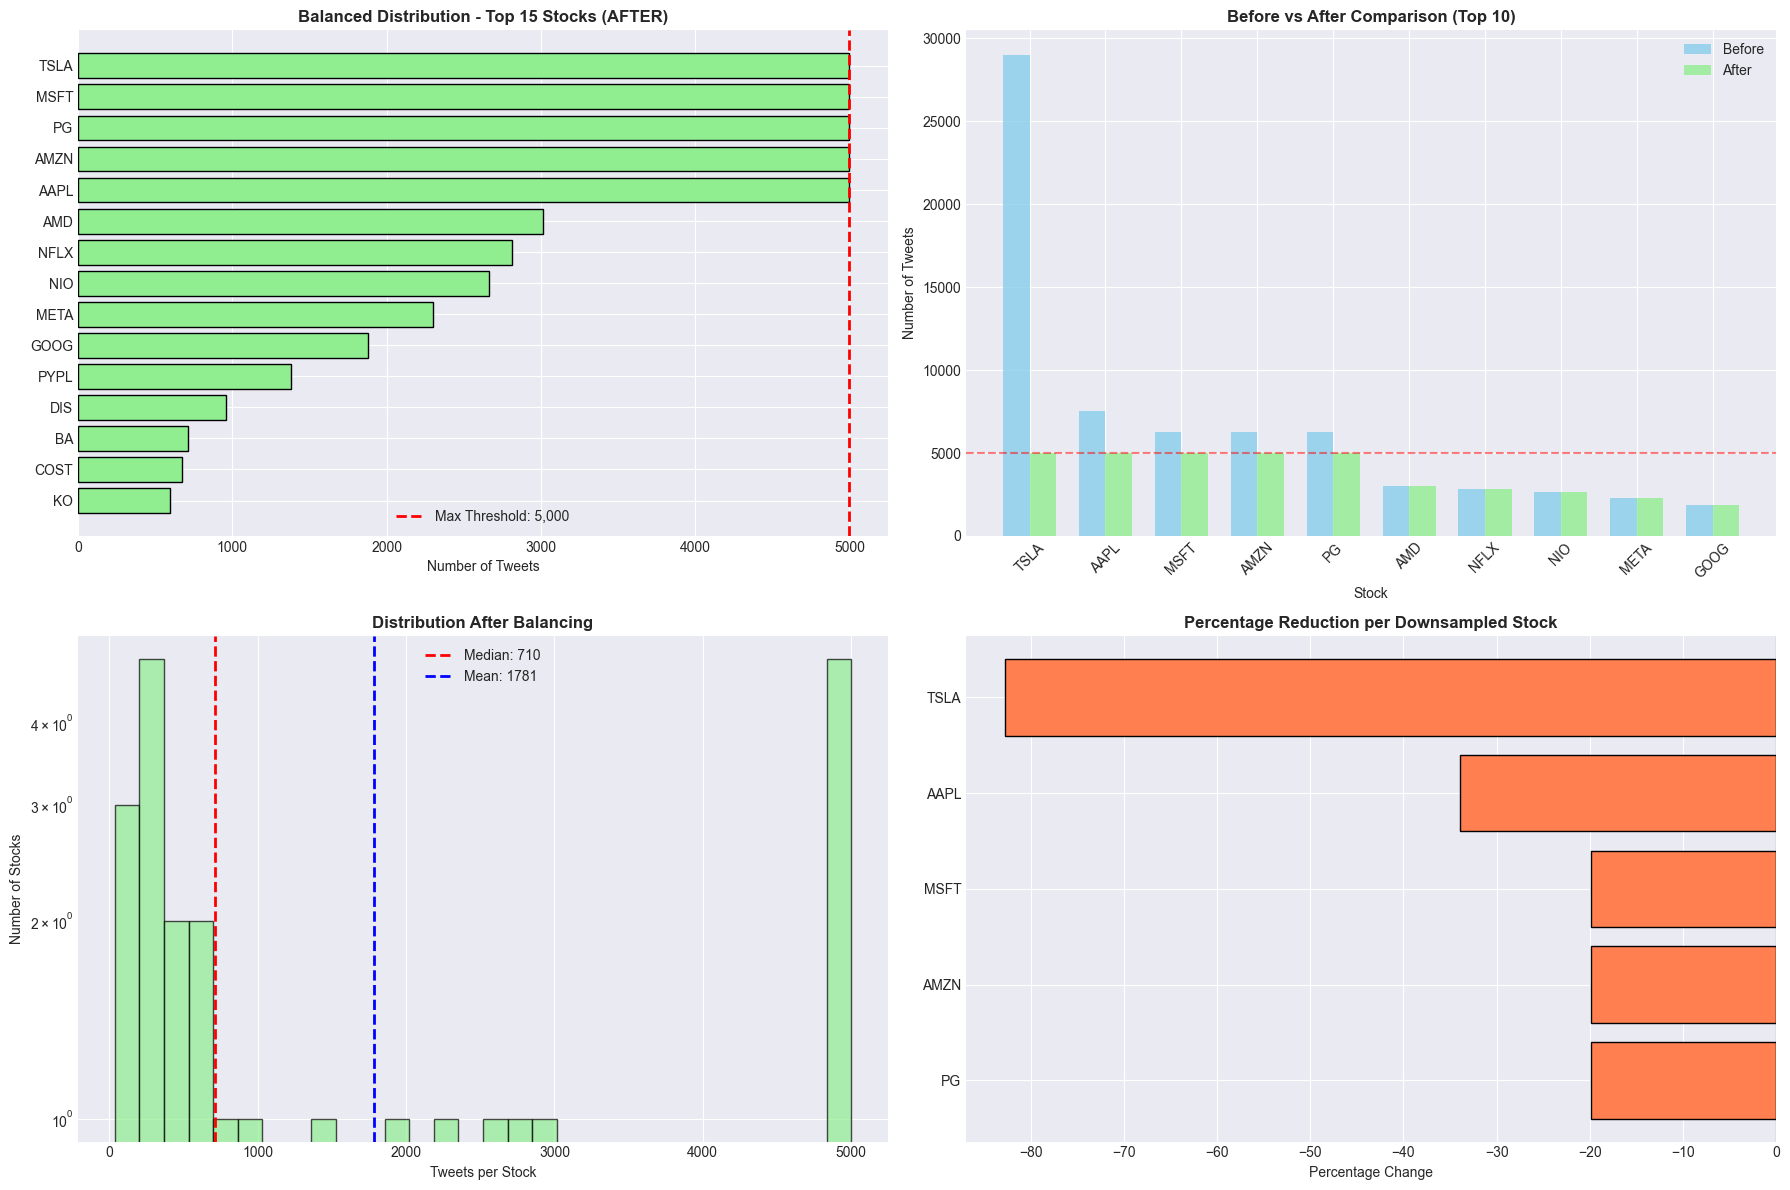

In [9]:
# Visualize balanced distribution
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# 1. Top 15 stocks AFTER
top_15_after = stock_counts_after.head(15)
axes[0, 0].barh(range(len(top_15_after)), top_15_after.values, color='lightgreen', edgecolor='black')
axes[0, 0].set_yticks(range(len(top_15_after)))
axes[0, 0].set_yticklabels(top_15_after.index)
axes[0, 0].set_xlabel('Number of Tweets')
axes[0, 0].set_title('Balanced Distribution - Top 15 Stocks (AFTER)', fontsize=12, fontweight='bold')
axes[0, 0].invert_yaxis()
axes[0, 0].axvline(MAX_TWEETS_PER_STOCK, color='red', linestyle='--', linewidth=2, label=f'Max Threshold: {MAX_TWEETS_PER_STOCK:,}')
axes[0, 0].legend()

# 2. Before vs After comparison (Top 10)
top_10_stocks = stock_counts_before.head(10).index
x = np.arange(len(top_10_stocks))
width = 0.35

before_vals = [stock_counts_before[stock] for stock in top_10_stocks]
after_vals = [stock_counts_after[stock] for stock in top_10_stocks]

axes[0, 1].bar(x - width/2, before_vals, width, label='Before', alpha=0.8, color='skyblue')
axes[0, 1].bar(x + width/2, after_vals, width, label='After', alpha=0.8, color='lightgreen')
axes[0, 1].set_xlabel('Stock')
axes[0, 1].set_ylabel('Number of Tweets')
axes[0, 1].set_title('Before vs After Comparison (Top 10)', fontsize=12, fontweight='bold')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(top_10_stocks, rotation=45)
axes[0, 1].legend()
axes[0, 1].axhline(MAX_TWEETS_PER_STOCK, color='red', linestyle='--', alpha=0.5, label='Threshold')

# 3. Distribution histogram AFTER
axes[1, 0].hist(stock_counts_after.values, bins=30, edgecolor='black', alpha=0.7, color='lightgreen')
axes[1, 0].axvline(stock_counts_after.median(), color='red', linestyle='--', 
               linewidth=2, label=f'Median: {stock_counts_after.median():.0f}')
axes[1, 0].axvline(stock_counts_after.mean(), color='blue', linestyle='--', 
               linewidth=2, label=f'Mean: {stock_counts_after.mean():.0f}')
axes[1, 0].set_xlabel('Tweets per Stock')
axes[1, 0].set_ylabel('Number of Stocks')
axes[1, 0].set_title('Distribution After Balancing', fontsize=12, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].set_yscale('log')

# 4. Percentage change per stock
pct_changes = []
stocks_changed = []
for stock in stocks_to_downsample.index:
    before = stock_counts_before[stock]
    after = stock_counts_after[stock]
    pct_change = ((after - before) / before) * 100
    pct_changes.append(pct_change)
    stocks_changed.append(stock)

axes[1, 1].barh(range(len(stocks_changed)), pct_changes, color='coral', edgecolor='black')
axes[1, 1].set_yticks(range(len(stocks_changed)))
axes[1, 1].set_yticklabels(stocks_changed)
axes[1, 1].set_xlabel('Percentage Change')
axes[1, 1].set_title('Percentage Reduction per Downsampled Stock', fontsize=12, fontweight='bold')
axes[1, 1].axvline(0, color='black', linewidth=0.8)
axes[1, 1].invert_yaxis()

plt.tight_layout()
plt.show()


## 4. Save Balanced Dataset


In [10]:
# Save balanced dataset
output_path = 'data/processed/balanced_tweets_stock_data.csv'
balanced_df.to_csv(output_path, index=False)

